In [ ]:
!pip install autogluon

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
import pandas as pd
from random import randrange, uniform
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_archivo = '/content/drive/MyDrive/TFM/datos_100_por_ciento.csv'
datos_100_por_ciento = pd.read_csv(ruta_archivo)

In [ ]:
for etiqueta in [0,1,2,3]:
  if etiqueta == 0:
    df_ = datos_100_por_ciento[datos_100_por_ciento['labels'] == 0]

    # Seleccionar 42,386 filas al azar
    df_balanceado = df_.sample(n=42386, random_state=42)
  else:
    df_ = datos_100_por_ciento[datos_100_por_ciento['labels'] == etiqueta]

    df_etiqueta = df_.sample(n=42386, random_state=42)
    df_balanceado = pd.concat([df_balanceado, df_etiqueta], axis=0)

df_balanceado.reset_index(drop=True, inplace=True)

In [ ]:
def particion(data_, frac):

  datos_por_ciento = data_.sample(frac=frac*0.01, random_state=42)
  return datos_por_ciento

In [ ]:
datos_20_por_ciento = particion(df_balanceado, 20)
datos_50_por_ciento = particion(df_balanceado, 50)
datos_70_por_ciento = particion(df_balanceado, 70)
datos_100_por_ciento = df_balanceado

In [ ]:
x_train20,x_test20,y_train20,y_test20 = train_test_split(datos_20_por_ciento.drop(columns = ['labels'] , axis = 1) , datos_20_por_ciento['labels'] , test_size = 0.3, random_state=10)
x_train50,x_test50,y_train50,y_test50 = train_test_split(datos_50_por_ciento.drop(columns = ['labels'] , axis = 1) , datos_50_por_ciento['labels'] , test_size = 0.3, random_state=10)
x_train70,x_test70,y_train70,y_test70 = train_test_split(datos_70_por_ciento.drop(columns = ['labels'] , axis = 1) , datos_70_por_ciento['labels'] , test_size = 0.3, random_state=10)
x_train100,x_test100,y_train100,y_test100 = train_test_split(datos_100_por_ciento.drop(columns = ['labels'] , axis = 1) , datos_100_por_ciento['labels'] , test_size = 0.3, random_state=10)

In [ ]:
def normalizar(x_train, x_test):
  scaler_all_primero = StandardScaler().fit(x_train)
  X_train_norm = scaler_all_primero.transform(x_train)
  X_test_norm = scaler_all_primero.transform(x_test)
  return X_train_norm, X_test_norm

In [ ]:
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] != _id and y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] == _id:
                FN[index] += 1


    return class_id,TP, FP, TN, FN


In [ ]:
def especificidadd(TN,FP,frac):
  espe = [TN[i]/(TN[i] + FP[i]) for i in range(len(TN))]
  print(espe)
  print((espe[0] + espe[1] + espe[2] + espe[3])/4)
  return espe, (espe[0] + espe[1] + espe[2] + espe[3])/4

In [ ]:
def sensibilidad(TP, FN, frac):
  sens=[]
  for i in range(len(TP)):
      if (TP[i]+FN[i]) == 0:
          sens.append(0)
      else:
          se = TP[i]/(TP[i]+FN[i])
          sens.append(se)
  avg_s = (sens[0] + sens[1] + sens[2] + sens[3])/4
  print(sens)
  print(avg_s)
  return sens, avg_s

In [ ]:
def aciertos(TP, TN, FP, FN, frac):
  ac = [(TP[i]+TN[i])/(TP[i]+TN[i]+FP[i]+FN[i]) for i in range(len(TN))]
  print(ac)
  print((ac[0] + ac[1] + ac[2] + ac[3])/4)
  return ac, (ac[0] + ac[1] + ac[2] + ac[3])/4

In [ ]:
import psutil
import time
def memory_usage():
    process = psutil.Process()
    mem_usage = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    return mem_usage

# Keras

In [ ]:
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


def NN_dense(datos, frac):

  x_train,x_test,y_train,y_test = train_test_split(datos.drop(columns = ['labels'] , axis = 1) , datos['labels'] , test_size = frac, random_state=10)

  psutil.cpu_percent(interval=None)

  start_ram_fit = memory_usage()
  start_cpu_fit = psutil.cpu_percent(interval=1)
  start_time_fit = time.time()

  x_train_norm, x_test_norm = normalizar(x_train, x_test)
  # Convertir etiquetas a one-hot encoding
  y_train_one_hot = to_categorical(y_train, num_classes=4)
  y_test_one_hot = to_categorical(y_test, num_classes=4)

  #Mejor representación de clases: El formato one-hot encoded representa cada clase de manera equitativa
  #y evita cualquier tipo de orden o jerarquía implícita que podría ser malinterpretada por el modelo si las clases se representaran con enteros.

  # Definir la función que construye el modelo
  def build_model(hp):
      model = tf.keras.Sequential()
      model.add(layers.Input(shape=(x_train_norm.shape[1],)))

      # Añadir capas ocultas
      for i in range(hp.Int('num_layers', 1, 5)):
          model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
                                activation=hp.Choice('activation_' + str(i), ['relu', 'sigmoid', 'tanh'])))
          model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1))) #técnica de regularización en redes neuronales que ayuda a prevenir el sobreajuste durante el entrenamiento.
          #Consiste en desactivar (poner a cero) un porcentaje de unidades (neuronas) de la capa durante cada paso de entrenamiento, de manera aleatoria. Red más robusta


      model.add(layers.Dense(4, activation='softmax'))

      model.compile(optimizer=tf.keras.optimizers.Adam(
          hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4])),
          loss='categorical_crossentropy',
          metrics=['accuracy'])

      return model

  tuner = kt.Hyperband(build_model,
                      objective='val_accuracy',
                      max_epochs=10,
                      factor=3)

  early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

  checkpoint = ModelCheckpoint('/content/drive/MyDrive/TFM/NN_dense_{epoch}.keras', monitor='val_accuracy', save_best_only=True) #Guarda el modelo después de cada epoch o cuando se observa una mejora en una métrica específica en el conjunto de validación.


  class PrintLearningRate(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          print("\nLearning rate:", self.model.optimizer.lr.numpy())


  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6) #Reduce la tasa de aprendizaje cuando una métrica específica ha dejado de mejorar.

  tuner.search(x_train_norm, y_train_one_hot, epochs=10, validation_split=0.1, callbacks=[early_stopping])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  try:
    print(best_hps)
    print(best_hps.get('learning_rate'))
    print(best_hps.get('num_layers'))
    for i in range(1, best_hps.get('num_layers') + 1):
      print('units_' + str(i), best_hps.get('units_' + str(i)))
      print('units_' + str(i),best_hps.get('activation_' + str(i)))
      print('dropout_' + str(i),best_hps.get('dropout_' + str(i)))
  except:
    print('No se puede')

  model = tuner.hypermodel.build(best_hps)

  History_pretrained = model.fit(x_train_norm, y_train_one_hot, epochs=60, validation_split=0.1, callbacks = [early_stopping, reduce_lr, PrintLearningRate(), checkpoint])
  model.summary()
  try:
    print(tf.keras.utils.plot_model(model, show_shapes=True))
  except:
    print('No se puede plotear')
  model.save('/content/drive/MyDrive/TFM/' +"model_tuner_NN.h5")

  val_acc_per_epoch = History_pretrained.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))


  end_ram_fit = memory_usage()
  end_cpu_fit = psutil.cpu_percent(interval=1)
  end_time_fit = time.time()

  ram_used_fit = end_ram_fit - start_ram_fit
  cpu_used_fit = end_cpu_fit - start_cpu_fit
  time_used_fit = end_time_fit - start_time_fit

  print(f'RAM usada durante fit: {ram_used_fit:.2f} MB')
  print(f'CPU usada durante fit: {cpu_used_fit:.2f}%')
  print(f'Tiempo de ejecución durante fit: {time_used_fit:.2f} segundos')

  start_ram_predict = memory_usage()
  start_cpu_predict = psutil.cpu_percent(interval=1)
  start_time_predict = time.time()

  test_loss, test_acc = model.evaluate(x_test_norm, y_test_one_hot)
  y_pred = model.predict(x_test_norm)

  end_ram_predict = memory_usage()
  end_cpu_predict = psutil.cpu_percent(interval=1)
  end_time_predict = time.time()

  ram_used_predict = end_ram_predict - start_ram_predict
  cpu_used_predict = end_cpu_predict - start_cpu_predict
  time_used_predict = end_time_predict - start_time_predict

  print(f'RAM usada durante predict: {ram_used_predict:.2f} MB')
  print(f'CPU usada durante predict: {cpu_used_predict:.2f}%')
  print(f'Tiempo de ejecución durante predict: {time_used_predict:.2f} segundos')
  # Convertir las predicciones a etiquetas de clase
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = np.argmax(y_test_one_hot, axis=1)

  conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
  print("Matriz de Confusión:")
  print(conf_matrix)

  class_report = classification_report(y_true_classes, y_pred_classes)
  print("\nInforme de Clasificación:")
  print(class_report)

  try:
    print('Accuracy del modelo en datos de prueba:', test_acc)
    class_id, TP, FP, TN, FN = perf_measure(y_true_classes, y_pred_classes)
    print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')
    print('Especificidad')
    espe = especificidadd(TN,FP, frac)
    print('Sensibilidad')
    sens = sensibilidad(TP, FN, frac)
    print('Aciertos')
    ac= aciertos(TP, TN, FP, FN, frac)
  except:
    print('No se puede')

  num_epochs = len(History_pretrained.history['loss'])

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["loss"], label = "train_loss")
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["val_loss"], label = "val_loss")
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["accuracy"], label = "train_acc")
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["val_accuracy"], label = "val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

  return y_pred_classes, y_true_classes, y_pred, y_test_one_hot

<ipython-input-15-e424d9b0adf4>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Trial 30 Complete [00h 00m 47s]
val_accuracy: 0.8201887607574463

Best val_accuracy So Far: 0.8838894367218018
Total elapsed time: 00h 42m 49s
0.001
4
units_1 160
units_1 relu
dropout_1 0.0
units_2 352
units_2 sigmoid
dropout_2 0.2
units_3 352
units_3 sigmoid
dropout_3 0.2
units_4 256
units_4 sigmoid
dropout_4 0.4
Epoch 1/60
3336/3338 [============================>.] - ETA: 0s - loss: 0.3648 - accuracy: 0.8495
Learning rate: 0.001
3338/3338 [==============================] - 33s 10ms/step - loss: 0.3649 - accuracy: 0.8495 - val_loss: 0.3117 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 2/60
3334/3338 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8739
Learning rate: 0.001
3338/3338 [==============================] - 29s 9ms/step - loss: 0.3007 - accuracy: 0.8738 - val_loss: 0.3055 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/60
3336/3338 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8796
Learning rate: 0.001
3338/3338 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Best epoch: 29
RAM usada durante fit: 339.43 MB
CPU usada durante fit: -96.00%
Tiempo de ejecución durante fit: 3646.35 segundos
1590/1590 [==============================] - 6s 3ms/step
RAM usada durante predict: 15.54 MB
CPU usada durante predict: -1.00%
Tiempo de ejecución durante predict: 12.70 segundos
Matriz de Confusión:
[[11159   756   239   504]
 [  783 10720  1215    58]
 [  174   889 11721     9]
 [  195    50    10 12382]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     12658
           1       0.86      0.84      0.85     12776
           2       0.89      0.92      0.90     12793
           3       0.96      0.98      0.97     12637

    accuracy                           0.90     50864
   macro avg       0.90      0.90      0.90     50864
weighted avg       0.90      0.90      0.90     50864

Accuracy del modelo en datos de prueba: 0.9040185809135437
TP: [11159, 10720, 11721, 12382], FP: [11

(array([2, 2, 2, ..., 2, 1, 2]),
 array([2, 2, 2, ..., 2, 1, 2]),
 array([[1.06511180e-07, 1.59593640e-07, 9.99999702e-01, 1.16873481e-11],
        [1.88096255e-01, 9.45922881e-02, 7.17310965e-01, 4.16869909e-07],
        [2.88074631e-07, 7.37127095e-07, 9.99998868e-01, 2.58036838e-11],
        ...,
        [1.10076835e-05, 3.16382289e-01, 6.83606207e-01, 5.91786659e-07],
        [7.25965388e-03, 9.92657602e-01, 8.22844668e-05, 4.00313610e-07],
        [1.29730050e-02, 2.50958285e-04, 9.86776114e-01, 1.19082157e-08]],
       dtype=float32),
 array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]], dtype=float32))

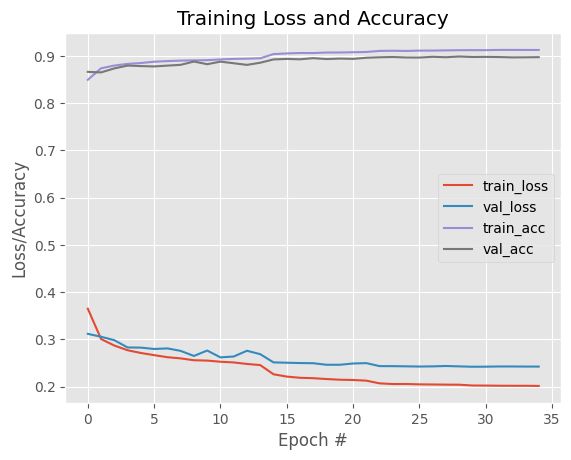

In [ ]:
NN_dense(datos_100_por_ciento, 0.3)

In [ ]:
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


def NN_dense_100(datos, frac):

  x_train,x_test,y_train,y_test = train_test_split(datos.drop(columns = ['labels'] , axis = 1) , datos['labels'] , test_size = frac, random_state=10)

  psutil.cpu_percent(interval=None)

  start_ram_fit = memory_usage()
  start_cpu_fit = psutil.cpu_percent(interval=1)
  start_time_fit = time.time()

  x_train_norm, x_test_norm = normalizar(x_train, x_test)
  # Convertir etiquetas a one-hot encoding
  y_train_one_hot = to_categorical(y_train, num_classes=4)
  y_test_one_hot = to_categorical(y_test, num_classes=4)

  model = tf.keras.Sequential()
  # Primera capa densa con 288 unidades y activación tanh
  model.add(layers.Input(shape=(x_train_norm.shape[1],)))

  model.add(layers.Dense(160, activation='relu'))

  # Segunda capa densa con 352 unidades y activación sigmoid
  model.add(layers.Dense(352, activation='sigmoid'))

  # Capa Dropout con tasa de 0.2
  model.add(layers.Dropout(0.2))

  # Tercera capa densa con 352 unidades y activación sigmoid
  model.add(layers.Dense(352, activation='sigmoid'))

  # Capa Dropout con tasa de 0.2
  model.add(layers.Dropout(0.2))

  # Cuarta capa densa con 256 unidades y activación sigmoid
  model.add(layers.Dense(256, activation='sigmoid'))

  # Capa Dropout con tasa de 0.4
  model.add(layers.Dropout(0.4))

  # Capa de salida con 4 unidades y activación softmax
  model.add(layers.Dense(4, activation='softmax'))


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

  class PrintLearningRate(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          print("\nLearning rate:", self.model.optimizer.lr.numpy())


  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


  History_pretrained = model.fit(x_train_norm, y_train_one_hot, epochs=80, validation_split=0.1, callbacks = [early_stopping, reduce_lr, PrintLearningRate()])
  model.summary()
  try:
    print(tf.keras.utils.plot_model(model, show_shapes=True))
  except:
    print('No se puede plotear')
  # model.save('/content/drive/MyDrive/TFM/' +"model_keras_NN_100.h5")

  val_acc_per_epoch = History_pretrained.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))


  end_ram_fit = memory_usage()
  end_cpu_fit = psutil.cpu_percent(interval=1)
  end_time_fit = time.time()

  ram_used_fit = end_ram_fit - start_ram_fit
  cpu_used_fit = end_cpu_fit - start_cpu_fit
  time_used_fit = end_time_fit - start_time_fit

  print(f'RAM usada durante fit: {ram_used_fit:.2f} MB')
  print(f'CPU usada durante fit: {cpu_used_fit:.2f}%')
  print(f'Tiempo de ejecución durante fit: {time_used_fit:.2f} segundos')

  start_ram_predict = memory_usage()
  start_cpu_predict = psutil.cpu_percent(interval=1)
  start_time_predict = time.time()

  test_loss, test_acc = model.evaluate(x_test_norm, y_test_one_hot)
  y_pred = model.predict(x_test_norm)

  end_ram_predict = memory_usage()
  end_cpu_predict = psutil.cpu_percent(interval=1)
  end_time_predict = time.time()

  ram_used_predict = end_ram_predict - start_ram_predict
  cpu_used_predict = end_cpu_predict - start_cpu_predict
  time_used_predict = end_time_predict - start_time_predict

  print(f'RAM usada durante predict: {ram_used_predict:.2f} MB')
  print(f'CPU usada durante predict: {cpu_used_predict:.2f}%')
  print(f'Tiempo de ejecución durante predict: {time_used_predict:.2f} segundos')

  # Convertir las predicciones a etiquetas de clase
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = np.argmax(y_test_one_hot, axis=1)

  conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
  print("Matriz de Confusión:")
  print(conf_matrix)

  class_report = classification_report(y_true_classes, y_pred_classes)
  print("\nInforme de Clasificación:")
  print(class_report)

  try:
    print('Accuracy del modelo en datos de prueba:', test_acc)
    class_id, TP, FP, TN, FN = perf_measure(y_true_classes, y_pred_classes)
    print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')
    print('Especificidad')
    espe = especificidadd(TN,FP, frac)
    print('Sensibilidad')
    sens = sensibilidad(TP, FN, frac)
    print('Aciertos')
    ac= aciertos(TP, TN, FP, FN, frac)
  except:
    print('No se puede')

  num_epochs = len(History_pretrained.history['loss'])

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["loss"], label = "train_loss")
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["val_loss"], label = "val_loss")
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["accuracy"], label = "train_acc")
  plt.plot(np.arange(0, num_epochs), History_pretrained.history["val_accuracy"], label = "val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

  return y_pred_classes, y_true_classes, y_pred, y_test_one_hot

# Tensorflow

https://medium.com/analytics-vidhya/how-to-write-a-neural-network-in-tensorflow-from-scratch-without-using-keras-e056bb143d78

In [ ]:
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual.iloc[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual.iloc[i] != y_pred[i]:
                FP[index] += 1
            if y_actual.iloc[i] != _id and y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual.iloc[i] == _id:
                FN[index] += 1


    return class_id,TP, FP, TN, FN


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import numpy as np


def NN_tensorflow(datos, frac):

  x_train,x_test,y_train,y_test = train_test_split(datos.drop(columns = ['labels'] , axis = 1) , datos['labels'] , test_size = frac, random_state=10)
  # Definir las variables
  num_features = x_train.shape[1]
  num_hidden_units1 = 160
  num_hidden_units2 = 352
  num_hidden_units3 = 352
  num_hidden_units4 = 256
  num_classes = len(np.unique(y_train))  # Ajusta el número de clases según tus datos

  x_train_norm, x_test_norm = normalizar(x_train, x_test)
  x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_norm, y_train, test_size=0.1, random_state=42)

  # Convertir los datos a tensores de TensorFlow
  x_train_tensor = tf.convert_to_tensor(x_train_split, dtype=tf.float32)
  x_val_tensor = tf.convert_to_tensor(x_val_split, dtype=tf.float32)
  x_test_tensor = tf.convert_to_tensor(x_test_norm, dtype=tf.float32)


  y_train_one_hot = tf.keras.utils.to_categorical(y_train_split, num_classes)
  y_val_one_hot = tf.keras.utils.to_categorical(y_val_split, num_classes)
  y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

  # Convertir las etiquetas one-hot a tensores
  y_train_tensor = tf.convert_to_tensor(y_train_one_hot, dtype=tf.float32)
  y_val_tensor = tf.convert_to_tensor(y_val_one_hot, dtype=tf.float32)
  y_test_tensor = tf.convert_to_tensor(y_test_one_hot, dtype=tf.float32)

  # Definir los pesos y sesgos para cada capa
  weights1 = tf.Variable(tf.random.normal([num_features, num_hidden_units1]))
  biases1 = tf.Variable(tf.zeros([num_hidden_units1]))

  weights2 = tf.Variable(tf.random.normal([num_hidden_units1, num_hidden_units2]))
  biases2 = tf.Variable(tf.zeros([num_hidden_units2]))

  weights3 = tf.Variable(tf.random.normal([num_hidden_units2, num_hidden_units3]))
  biases3 = tf.Variable(tf.zeros([num_hidden_units3]))

  weights4 = tf.Variable(tf.random.normal([num_hidden_units3, num_hidden_units4]))
  biases4 = tf.Variable(tf.zeros([num_hidden_units4]))

  weights5 = tf.Variable(tf.random.normal([num_hidden_units4, num_classes]))
  biases5 = tf.Variable(tf.zeros([num_classes]))

  # Función de dropout
  def apply_dropout(layer, rate):
      return tf.nn.dropout(layer, rate)

  train_loss_history = []
  train_accuracy_history = []
  val_loss_history = []
  val_accuracy_history = []

  # Definir la estructura de la red neuronal
  def neural_network(x):
      # Capa oculta 1
      hidden_layer1 = tf.nn.relu(tf.matmul(x, weights1) + biases1)

      # Capa oculta 2
      hidden_layer2 = tf.nn.sigmoid(tf.matmul(hidden_layer1, weights2) + biases2)
      hidden_layer2 = apply_dropout(hidden_layer2, 0.2)

      # Capa oculta 3
      hidden_layer3 = tf.nn.sigmoid(tf.matmul(hidden_layer2, weights3) + biases3)
      hidden_layer3 = apply_dropout(hidden_layer3, 0.2)  # Dropout rate de 0.4

      # Capa oculta 4
      hidden_layer4 = tf.nn.sigmoid(tf.matmul(hidden_layer3, weights4) + biases4)
      hidden_layer4 = apply_dropout(hidden_layer4, 0.4)

      # Capa de salida
      output_layer = tf.matmul(hidden_layer4, weights5) + biases5
      return output_layer

  # Definir la función de pérdida y el optimizador
  def compute_loss(labels, predictions):
      return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=predictions)) #Propósito: Esta función calcula la entropía cruzada entre las etiquetas verdaderas
      #(en formato one-hot) y las predicciones del modelo (sin aplicar softmax). -sum(y_true * log(y_pred))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


  start_ram_train = memory_usage()
  start_cpu_train = psutil.cpu_percent(interval=1)
  start_time_train = time.time()

  # Entrenar el modelo
  epochs = 47
  batch_size = 128 #  Número de muestras que el modelo verá antes de actualizar los pesos.
  for epoch in range(epochs):
      for i in range(0, len(x_train_split), batch_size):
          batch_X = x_train_tensor[i:i+batch_size]
          batch_y = y_train_tensor[i:i+batch_size]

          with tf.GradientTape() as tape: #para la diferenciación automática, lo que permite calcular los gradientes necesarios para la optimización.
              predictions = neural_network(batch_X) # Calcula las predicciones de la red neuronal para el lote de entrada batch_X
              loss = compute_loss(labels=batch_y, predictions=predictions)

          gradients = tape.gradient(loss, [weights1, biases1, weights2, biases2, weights3, biases3, weights4, biases4, weights5, biases5]) # Calcula los gradientes de la pérdida con respecto a los pesos y sesgos del modelo.
          # Los gradientes indican la dirección y magnitud de los cambios necesarios para minimizar la pérdida.
          optimizer.apply_gradients(zip(gradients, [weights1, biases1, weights2, biases2, weights3, biases3, weights4, biases4, weights5, biases5])) #  Actualiza los pesos y sesgos del modelo usando los gradientes calculados.
          # zip(gradients, [weights1, biases1, weights2, biases2, weights3, biases3]) empareja cada gradiente con su correspondiente peso o sesgo.

      print("Epoch:", epoch+1, "Loss:", loss.numpy())


      train_loss = loss.numpy()
      train_accuracy = accuracy_score(y_train_split, np.argmax(neural_network(x_train_tensor).numpy(), axis=1))
      train_loss_history.append(train_loss)
      train_accuracy_history.append(train_accuracy)

      # Calcular el accuracy y la pérdida en el conjunto de validación
      val_loss = compute_loss(labels=y_val_tensor, predictions=neural_network(x_val_tensor)).numpy()
      val_accuracy = accuracy_score(y_val_split, np.argmax(neural_network(x_val_tensor).numpy(), axis=1))
      val_loss_history.append(val_loss)
      val_accuracy_history.append(val_accuracy)

      print("Epoch:", epoch+1, "Train Loss:", train_loss, "Train Accuracy:", train_accuracy,
            "Val Loss:", val_loss, "Val Accuracy:", val_accuracy)


  end_ram_train = memory_usage()
  end_cpu_train = psutil.cpu_percent(interval=1)
  end_time_train = time.time()

  ram_used_train = end_ram_train - start_ram_train
  cpu_used_train = end_cpu_train - start_cpu_train
  time_used_train = end_time_train - start_time_train

  print(f'RAM usada durante predict: {ram_used_train:.2f} MB')
  print(f'CPU usada durante predict: {cpu_used_train:.2f}%')
  print(f'Tiempo de ejecución durante predict: {time_used_train:.2f} segundos')

  start_ram_predict = memory_usage()
  start_cpu_predict = psutil.cpu_percent(interval=1)
  start_time_predict = time.time()

  predictions_test = neural_network(x_test_tensor)
  test_loss = compute_loss(labels=y_test_tensor, predictions=predictions_test)
  print("Test Loss:", test_loss.numpy())
  predicted_labels = np.argmax(predictions_test, axis=1)

  end_ram_predict = memory_usage()
  end_cpu_predict = psutil.cpu_percent(interval=1)
  end_time_predict = time.time()

  ram_used_predict = end_ram_predict - start_ram_predict
  cpu_used_predict = end_cpu_predict - start_cpu_predict
  time_used_predict = end_time_predict - start_time_predict

  print(f'RAM usada durante predict: {ram_used_predict:.2f} MB')
  print(f'CPU usada durante predict: {cpu_used_predict:.2f}%')
  print(f'Tiempo de ejecución durante predict: {time_used_predict:.2f} segundos')

  accuracy = accuracy_score(y_test100, predicted_labels)
  print("Accuracy:", accuracy)

  conf_matrix = confusion_matrix(y_test100, predicted_labels)
  print("Confusion Matrix:")
  print(conf_matrix)

  class_report = classification_report(y_test100, predicted_labels)
  print("Informe de Clasificación:")
  print(class_report)

  try:
    class_id, TP, FP, TN, FN = perf_measure(y_test100, predicted_labels)
    print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')
    print('Especificidad')
    espe = especificidadd(TN,FP, 20)
    print('Sensibilidad')
    sens = sensibilidad(TP, FN, 20)
    print('Aciertos')
    ac= aciertos(TP, TN, FP, FN, 20)
  except:
    print('No se puede')

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs+1), train_loss_history, label='Train Loss')
  plt.plot(range(1, epochs+1), val_loss_history, label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs+1), train_accuracy_history, label='Train Accuracy')
  plt.plot(range(1, epochs+1), val_accuracy_history, label='Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.show()

Epoch: 1 Loss: 0.7381328
Epoch: 1 Train Loss: 0.7381328 Train Accuracy: 0.7334112740141557 Val Loss: 1.219667 Val Accuracy: 0.7362234580384226
Epoch: 2 Loss: 0.5660263
Epoch: 2 Train Loss: 0.5660263 Train Accuracy: 0.7842096393663633 Val Loss: 0.544263 Val Accuracy: 0.7849258510279744
Epoch: 3 Loss: 0.261566
Epoch: 3 Train Loss: 0.261566 Train Accuracy: 0.8170605830805527 Val Loss: 0.46324307 Val Accuracy: 0.8139956184698348
Epoch: 4 Loss: 0.4005379
Epoch: 4 Train Loss: 0.4005379 Train Accuracy: 0.832195820694304 Val Loss: 0.4185061 Val Accuracy: 0.8298365352207617
Epoch: 5 Loss: 0.39833313
Epoch: 5 Train Loss: 0.39833313 Train Accuracy: 0.8422543815301652 Val Loss: 0.39088538 Val Accuracy: 0.8421385237613751
Epoch: 6 Loss: 0.27527335
Epoch: 6 Train Loss: 0.27527335 Train Accuracy: 0.8489109369733738 Val Loss: 0.36921898 Val Accuracy: 0.8463936636332996
Epoch: 7 Loss: 0.24366209
Epoch: 7 Train Loss: 0.24366209 Train Accuracy: 0.8533345972362656 Val Loss: 0.36080626 Val Accuracy: 0.8494

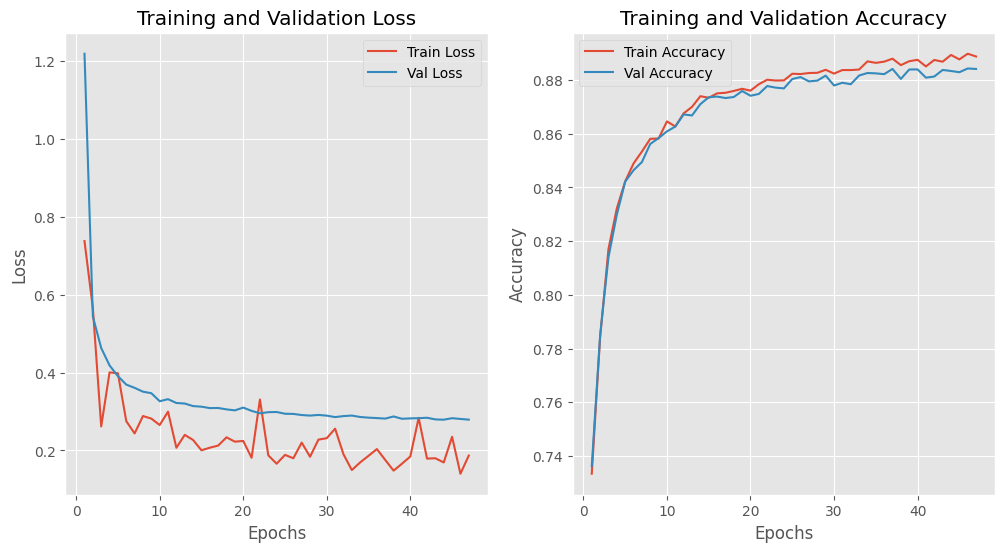

In [ ]:
NN_tensorflow(datos_100_por_ciento, 0.3)

# AutoGluon

In [ ]:
def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual.iloc[i] == y_pred.iloc[i] == _id:
                TP[index] += 1
            if y_pred.iloc[i] == _id and y_actual.iloc[i] != y_pred.iloc[i]:
                FP[index] += 1
            if y_actual.iloc[i] != _id and y_pred.iloc[i] != _id:
                TN[index] += 1
            if y_pred.iloc[i] != _id and y_actual.iloc[i] == _id:
                FN[index] += 1


    return class_id,TP, FP, TN, FN


In [ ]:
datos_entrenamiento_20 = pd.concat([x_train20, y_train20], axis=1)
datos_entrenamiento_50 = pd.concat([x_train50, y_train50], axis=1)
datos_entrenamiento_70 = pd.concat([x_train70, y_train70], axis=1)
datos_entrenamiento_100 = pd.concat([x_train100, y_train100], axis=1)
datos_entrenamiento_20

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,valence,labels
73256,0.080700,0.556,0.657,0.000000,-5.129,0.9650,0.688,1
82903,0.049400,0.609,0.644,0.000069,-4.879,0.0490,0.564,1
117303,0.030000,0.541,0.671,0.002420,-7.434,0.0408,0.160,2
160492,0.973000,0.447,0.110,0.947000,-60.000,0.0356,0.219,3
140792,0.977000,0.178,0.347,0.887000,-19.087,0.0477,0.288,3
...,...,...,...,...,...,...,...,...
162249,0.991000,0.376,0.185,0.610000,-19.377,0.0499,0.192,3
86500,0.000123,0.507,0.958,0.000061,-4.688,0.0588,0.362,2
128347,0.940000,0.536,0.245,0.889000,-16.975,0.0339,0.453,3
90242,0.094800,0.634,0.911,0.012500,-4.681,0.0538,0.373,2


In [ ]:
datos_test_20 = pd.concat([x_test20, y_test20], axis=1)
datos_test_50 = pd.concat([x_test50, y_test50], axis=1)
datos_test_70 = pd.concat([x_test70, y_test70], axis=1)
datos_test_100 = pd.concat([x_test100, y_test100], axis=1)
datos_test_20

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,valence,labels
140739,0.71400,0.104,0.11000,0.539000,-14.669,0.0479,0.0358,3
127586,0.98900,0.328,0.00348,0.912000,-60.000,0.0583,0.2660,3
95110,0.00441,0.194,0.93300,0.689000,-3.711,0.0433,0.8870,2
15596,0.83500,0.510,0.31500,0.144000,-15.097,0.0562,0.5540,0
142032,0.98900,0.528,0.21800,0.904000,-20.695,0.0404,0.3800,3
...,...,...,...,...,...,...,...,...
56032,0.15600,0.594,0.86700,0.000000,-7.744,0.0846,0.5060,1
16835,0.45200,0.767,0.25100,0.871000,-15.569,0.0499,0.4560,0
5403,0.96600,0.454,0.13600,0.000024,-12.915,0.0367,0.4020,0
134023,0.91300,0.637,0.14300,0.906000,-17.337,0.0376,0.1160,3


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Definir la columna objetivo
label_column = 'labels'

predictor = TabularPredictor(label=label_column)

predictor.fit(datos_entrenamiento_100)

predictions = predictor.predict(datos_test_100)

No path specified. Models will be saved in: "AutogluonModels/ag-20240601_180503"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240601_180503"
=================== System

[1000]	valid_set's multi_error: 0.0692


	0.9316	 = Validation score   (accuracy)
	45.56s	 = Training   runtime
	1.04s	 = Validation runtime
Fitting model: LightGBM ...
	0.9308	 = Validation score   (accuracy)
	7.89s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9224	 = Validation score   (accuracy)
	67.83s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9232	 = Validation score   (accuracy)
	79.78s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: CatBoost ...
	0.9328	 = Validation score   (accuracy)
	270.68s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9116	 = Validation score   (accuracy)
	21.26s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9116	 = Validation score   (accuracy)
	24.21s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost ...
	0.9316	 = Validation score   (accuracy)
	10.97s	 = Training   runtime
	0.09s

In [ ]:
best_model_info = predictor.leaderboard(extra_info=True)
print(best_model_info)

                  model  score_val eval_metric  pred_time_val    fit_time  \
0   WeightedEnsemble_L2     0.9336    accuracy       1.065638  316.533150   
1              CatBoost     0.9328    accuracy       0.025334  270.677791   
2         LightGBMLarge     0.9316    accuracy       0.078964    9.734381   
3               XGBoost     0.9316    accuracy       0.088472   10.965903   
4            LightGBMXT     0.9316    accuracy       1.039119   45.563263   
5              LightGBM     0.9308    accuracy       0.054194    7.889087   
6      RandomForestEntr     0.9232    accuracy       0.408575   79.775166   
7      RandomForestGini     0.9224    accuracy       0.208997   67.830290   
8       NeuralNetFastAI     0.9156    accuracy       0.038920  151.309075   
9        ExtraTreesGini     0.9116    accuracy       0.230020   21.260563   
10       ExtraTreesEntr     0.9116    accuracy       0.239330   24.213601   
11       NeuralNetTorch     0.9108    accuracy       0.019948  198.153911   

In [ ]:
best_model_info[best_model_info['model'] == 'NeuralNetFastAI']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
8,NeuralNetFastAI,0.9156,accuracy,0.03892,151.309075,0.03892,151.309075,1,True,3,...,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 'auto', 'lr': 0.01, 'epochs': 'auto', 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}","{'epochs': 30, 'best_epoch': 27}","{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': ['text_ngram', 'text_as_category'], 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}","[acousticness, danceability, energy, instrumentalness, loudness, speechiness, valence]",None,None,None,None,[],[]


In [ ]:
best_model_info[best_model_info['model'] == 'NeuralNetTorch']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
11,NeuralNetTorch,0.9108,accuracy,0.019948,198.153911,0.019948,198.153911,1,True,12,...,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0003, 'weight_decay': 1e-06, 'proc.embed_min_categories': 4, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 4, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto'}","{'batch_size': 256, 'num_epochs': 56}","{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': ['text_ngram', 'text_as_category'], 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}","[acousticness, danceability, energy, instrumentalness, loudness, speechiness, valence]",None,None,None,None,[],[]


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

accuracy_scores = {}

for nombre_modelo in nombres_modelos:

    predicciones = predictor.predict(x_test100, model=nombre_modelo)

    accuracy = accuracy_score(y_test100, predicciones)
    class_id, TP, FP, TN, FN = perf_measure(y_test100, predicciones)
    print(f'TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}')
    print('Especificidad')
    espe = especificidadd(TN,FP, 20)
    print('Sensibilidad')
    sens = sensibilidad(TP, FN, 20)
    print('Aciertos')
    ac= aciertos(TP, TN, FP, FN, 20)
    accuracy_scores[nombre_modelo] = {}
    # Guardar la precisión en el diccionario
    accuracy_scores[nombre_modelo]['accuracy'] = accuracy
    accuracy_scores[nombre_modelo]['especificidad'] = espe
    accuracy_scores[nombre_modelo]['sensibilidad'] = sens
    accuracy_scores[nombre_modelo]['aciertos'] = ac


TP: [10172, 9697, 10732, 12175], FP: [2082, 3023, 2123, 860], TN: [36124, 35065, 35948, 37367], FN: [2486, 3079, 2061, 462]
Especificidad
[0.945505941475161, 0.9206311699222852, 0.944235770008668, 0.9775028121484814]
0.9469689233886489
Sensibilidad
[0.8036024648443671, 0.7590012523481527, 0.838896271398421, 0.9634406900371923]
0.8412351696570333
Aciertos
[0.9101918842403272, 0.8800330292544826, 0.917741428122051, 0.9740091223655237]
0.9204938659955961
TP: [10071, 9706, 10911, 12218], FP: [1803, 2953, 2311, 891], TN: [36403, 35135, 35760, 37336], FN: [2587, 3070, 1882, 419]
Especificidad
[0.952808459404282, 0.9224690191136315, 0.9392976281158887, 0.9766918670049964]
0.9478167434096997
Sensibilidad
[0.795623321219782, 0.7597056981840952, 0.8528882982881263, 0.966843396375722]
0.8437651785169313
Aciertos
[0.9136914123938346, 0.881586190625983, 0.9175644856873231, 0.9742450456118276]
0.921771783579742
TP: [11182, 10820, 11805, 12313], FP: [1068, 1661, 1505, 510], TN: [37138, 36427, 36566, 

In [ ]:
for nombre_modelo, accuracy in accuracy_scores.items():
    print(f"Modelo: {nombre_modelo}, Precisión: {accuracy['accuracy']}")
    print(f"Modelo: {nombre_modelo}, Especificidad: {accuracy['especificidad']}")
    print(f"Modelo: {nombre_modelo}, Sensibilidad: {accuracy['sensibilidad']}")
    print(f"Modelo: {nombre_modelo}, Aciertos: {accuracy['aciertos']}")

Modelo: KNeighborsUnif, Precisión: 0.8409877319911921
Modelo: KNeighborsUnif, Especificidad: ([0.945505941475161, 0.9206311699222852, 0.944235770008668, 0.9775028121484814], 0.9469689233886489)
Modelo: KNeighborsUnif, Sensibilidad: ([0.8036024648443671, 0.7590012523481527, 0.838896271398421, 0.9634406900371923], 0.8412351696570333)
Modelo: KNeighborsUnif, Aciertos: ([0.9101918842403272, 0.8800330292544826, 0.917741428122051, 0.9740091223655237], 0.9204938659955961)
Modelo: KNeighborsDist, Precisión: 0.8435435671594841
Modelo: KNeighborsDist, Especificidad: ([0.952808459404282, 0.9224690191136315, 0.9392976281158887, 0.9766918670049964], 0.9478167434096997)
Modelo: KNeighborsDist, Sensibilidad: ([0.795623321219782, 0.7597056981840952, 0.8528882982881263, 0.966843396375722], 0.8437651785169313)
Modelo: KNeighborsDist, Aciertos: ([0.9136914123938346, 0.881586190625983, 0.9175644856873231, 0.9742450456118276], 0.921771783579742)
Modelo: NeuralNetFastAI, Precisión: 0.9067316766278704
Modelo

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

label_column = 'labels'

predictor = TabularPredictor(label=label_column)

hyperparameters = {
    'NN_TORCH': {}
}

predictor.fit(train_data=datos_entrenamiento_100, hyperparameters=hyperparameters)

predictions = predictor.predict(datos_test_100)


No path specified. Models will be saved in: "AutogluonModels/ag-20240611_165431"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240611_165431"
=================== System

In [ ]:
trainer = predictor._trainer
model_names = trainer.get_model_names()
for model_name in model_names:
    model_info = trainer.get_model_info(model_name)
    print(f"Model: {model_name}")
    print(f"Hyperparameters: {model_info['hyperparameters']}")
    print(f"Score: {model_info['val_score']}")
    print("-" * 30)

Model: NeuralNetTorch
Hyperparameters: {'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0003, 'weight_decay': 1e-06, 'proc.embed_min_categories': 4, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 4, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto'}
Score: 0.888374052232519
------------------------------
Model: WeightedEnsemble_L2
Hyperparameters: {'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}
Score: 0.888374052232519
------------------------------


In [ ]:

import pandas as pd
from autogluon.tabular import TabularPredictor

label_column = 'labels'

predictor = TabularPredictor(label=label_column, path='/content/drive/MyDrive/TFM/AutoGluonModel')

hyperparameters = {
    'FASTAI': {}
}

predictor.fit(train_data=datos_entrenamiento_100, hyperparameters=hyperparameters)

predictor.save()




Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
Memory Avail:       10.10 GB / 12.67 GB (79.7%)
Disk Space Avail:   4.56 GB / 15.00 GB (30.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_qua

In [ ]:
trainer = predictor._trainer
model_names = trainer.get_model_names()
for model_name in model_names:
    model_info = trainer.get_model_info(model_name)
    print(f"Model: {model_name}")
    print(f"Hyperparameters: {model_info['hyperparameters']}")
    print(f"Score: {model_info['val_score']}")
    print("-" * 30)

Model: NeuralNetFastAI
Hyperparameters: {'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 'auto', 'lr': 0.01, 'epochs': 'auto', 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}
Score: 0.9156
------------------------------
Model: WeightedEnsemble_L2
Hyperparameters: {'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}
Score: 0.9156
------------------------------


# NUEVO CONJUNTO

In [ ]:
ruta_archivo = '/content/drive/MyDrive/TFM/new_test.csv'
new_test = pd.read_csv(ruta_archivo)

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

# Cargar el modelo
model = load_model('/content/drive/MyDrive/TFM/model_tuner_NN.h5')
x_train_norm, x_test_norm = normalizar(x_train100, new_test.iloc[:, :-1])
y_test_one_hot = to_categorical(new_test['labels'], num_classes=4)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

predictions = model.predict(x_test_norm)

predicted_labels = predictions.argmax(axis=1)

accuracy = accuracy_score(y_true_classes, predicted_labels)

print(f'Accuracy: {accuracy}')
print(confusion_matrix(y_true_classes, predicted_labels))

2/2 [==============================] - 0s 10ms/step
Accuracy: 0.5476190476190477
[[9 3 0 0]
 [3 7 3 0]
 [0 6 7 0]
 [3 1 0 0]]


In [ ]:
predicted_labels

array([2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0,
       2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 2])

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

model = load_model('/content/drive/MyDrive/TFM/model_tuner_NN.h5')
x_train_norm, x_test_norm = normalizar(x_train100, new_test.iloc[:, :-1])
y_test_one_hot = to_categorical(new_test['labels'], num_classes=4)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

predictions = model.predict(x_test_norm)

predicted_labels = predictions.argmax(axis=1)

accuracy = accuracy_score(y_true_classes, predicted_labels)

print(f'Accuracy: {accuracy}')


1/1 [==============================] - 0s 382ms/step
Accuracy: 0.5


In [ ]:
predicted_labels

array([2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0])

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import accuracy_score

predictor1 = TabularPredictor.load('/content/drive/MyDrive/TFM/AutoGluonModel')

predictions = predictor1.predict(new_test)

print(predictions)

performance = predictor1.evaluate(new_test)
accuracy = accuracy_score(new_test['labels'], predictions)
print(accuracy)
print(confusion_matrix(new_test['labels'], predictions))

print(performance)

0     2
1     1
2     2
3     2
4     1
5     1
6     1
7     1
8     1
9     0
10    0
11    1
12    1
13    1
14    1
15    2
16    0
17    0
18    0
19    0
20    1
21    0
22    2
23    1
24    2
25    2
26    0
27    0
28    0
29    1
30    1
31    1
32    2
33    2
34    0
35    0
36    1
37    0
38    0
39    0
40    1
41    2
Name: labels, dtype: int64
0.5476190476190477
[[9 3 0 0]
 [3 7 3 0]
 [0 6 7 0]
 [3 1 0 0]]
{'accuracy': 0.5476190476190477, 'balanced_accuracy': 0.4567307692307692, 'mcc': 0.3605151201611742}
